In [1]:
import math
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

import roboticstoolbox as rtb
import spatialmath as sm # provides objects for representing transformations
from swift import Swift # lightweight browser-based simulator which comes with the toolbox
import spatialgeometry as sg # utility package for dealing with geometric objects

In [2]:
robot = rtb.models.wx200()
print(robot)

ERobot: wx200 (by Interbotix), 8 joints (RRRRRRPP), 4 branches, dynamics, geometry, collision
┌──────┬─────────────────────┬───────┬───────────────────┬───────────────────────────────────────────┐
│ link │        link         │ joint │      parent       │            ETS: parent to link            │
├──────┼─────────────────────┼───────┼───────────────────┼───────────────────────────────────────────┤
│    0 │ /base_link          │       │ BASE              │ SE3()                                     │
│    1 │ /shoulder_link      │     0 │ /base_link        │ SE3(0, 0, 0.0716) ⊕ Rz(q0)                │
│    2 │ /upper_arm_link     │     1 │ /shoulder_link    │ SE3(0, 0, 0.03865) ⊕ Ry(q1)               │
│    3 │ /forearm_link       │     2 │ /upper_arm_link   │ SE3(0.05, 0, 0.2; 180°, -0°, 0°) ⊕ Ry(q2) │
│    4 │ /wrist_link         │     3 │ /forearm_link     │ SE3(0.2, 0, 0) ⊕ Ry(q3)                   │
│    5 │ /gripper_link       │     4 │ /wrist_link       │ SE3(0.065, 0, 0; -180°,

In [7]:
# Make the environment
env = Swift()

# Launch the simulator, will open a browser tab in your default
# browser (chrome is recommended)
# The realtime flag will ask the simulator to simulate as close as
# possible to realtime as apposed to as fast as possible
# We can also choose to see Swift within the notebook using the
# browser="notebook" flag
env.launch(realtime=True, browser="notebook")

# We can then add our robot to the simulator envionment
env.add(ob=robot)

# end-effector axes
ee_axes = sg.Axes(0.1)

# goal axes
goal_axes = sg.Axes(0.1)

# Add the axes to the environment
env.add(ee_axes)
env.add(goal_axes) 

2

In [4]:
robot.qz

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
# We can set the pose of the shape using the `.T` attribute.
# This pose can be either a spatialmat SE3 or a 4x4 ndarray
ee_axes.T = robot.fkine(robot.q, end='/ee_arm_link')

# Set the goal axes to something along the x axis
goal_axes.T = sm.SE3.Trans(0.5, 0.0, 0.5)

# step the environment to view the changes
env.step(0.05)

In [9]:
# Set all joint velocities to 0.1 rad/s
robot.qd = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

# Step the environment 100 times with a time step of 50 milliseconds
for _ in range(100):
    env.step(0.05)

In [10]:
# Our desired end-effector velocity
# A constant 0.1 m/s along the x-axis
ev = [0.1, 0.0, 0.0, 0.0, 0.0, 0.0]

# The base-frame manipulator Jacobian in the qr configuration
J = robot.jacob0(robot.qr, end='/ee_arm_link')

# Calculate the required joint velocities to achieve the desired end-effector velocity ev
dq = np.linalg.pinv(J) @ ev

# Visualise the results
print(np.round(dq, 4))

[-0.      0.4777  0.4493  0.0283 -0.    ]


In [11]:
# Make a new environment and add our robot
env = Swift()
env.launch(realtime=True, browser="notebook")
env.add(robot)

# Change the robot configuration to the ready position
robot.qr = np.zeros(8)
robot.q = robot.qr
dq_size = len(robot.qd) # number of actuators defined in rtb (faultily says 8 for WX200 arm, should be 6 including the fingers)
action_size = 5 # number of actuators we're actually using (5 for WX200 arm, since we dont use the fingers)

# Specify our desired end-effector velocity
ev = [0.0, 0.0, 0.0, 0.5, 0.0, 0.0]

# Specify our timestep
dt = 0.001
duration = 5

max_qd = np.zeros(8)
qd_history = []

# Step the sim to view the robot in this configuration
env.step(dt)

# Run the simulation for [duration] seconds
for _ in range(int(duration/dt)):

	# Work out the manipulator Jacobian using the current robot configuration
	J = robot.jacob0(robot.q, end='/ee_arm_link')

	# Since the robot has 7 joints, the Jacobian is not square, therefore we must
	# use the pseudoinverse (the pinv method)
	J_pinv = np.linalg.pinv(J)
	
	print(J_pinv.shape, len(ev))
	# Calculate the required joint velocities and apply to the robot
	robot.qd = np.concatenate([J_pinv @ ev, np.zeros(dq_size - action_size)])
	# robot.qd = np.zeros(8)
	# robot.qd[5] = 1.0
 
	max_qd = np.max(np.vstack([abs(robot.qd), max_qd]), axis=0)
	qd_history.append(np.copy(robot.q))

	# Step the simulator by dt seconds
	env.step(dt)
 
qd_history = np.array(qd_history)

(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(5, 6) 6
(

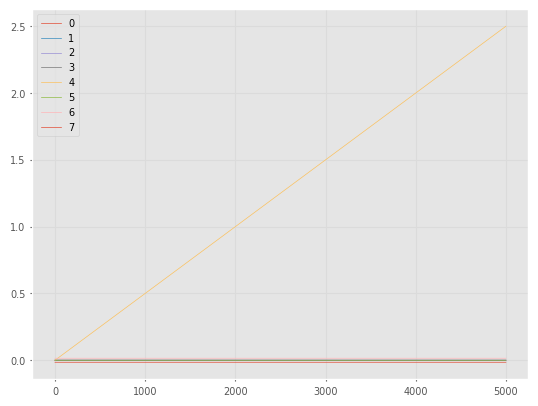

In [12]:
plt.plot(qd_history, label=np.arange(8))
plt.legend()
plt.show()

In [13]:
def angle_axis(T: np.ndarray, Td: np.ndarray) -> np.ndarray:
    """
    Returns the error vector between T and Td in angle-axis form.

    :param T: The current pose
    :param Tep: The desired pose

    :returns e: the error vector between T and Td
    """

    e = np.empty(6)

    # The position error
    e[:3] = Td[:3, -1] - T[:3, -1]

    R = Td[:3, :3] @ T[:3, :3].T

    li = np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])

    if np.linalg.norm(li) < 1e-6:
        # If li is a zero vector (or very close to it)

        # diagonal matrix case
        if np.trace(R) > 0:
            # (1,1,1) case
            a = np.zeros((3,))
        else:
            a = np.pi / 2 * (np.diag(R) + 1)
    else:
        # non-diagonal matrix case
        ln = np.linalg.norm(li)
        a = math.atan2(ln, np.trace(R) - 1) * li / ln

    e[3:] = a

    return e

def p_servo(
    Te: np.ndarray, Tep: np.ndarray, gain: np.ndarray, threshold: float = 0.1
) -> Tuple[np.ndarray, bool]:
    """
    Position-based servoing.

    Returns the end-effector velocity which will cause the robot to approach
    the desired pose.

    :param Te: The current pose of the end-effecor in the base frame.
    :type wTe: ndarray
    :param Tep: The desired pose of the end-effecor in the base frame.
    :type wTep: ndarray
    :param gain: The gain for the controller. A vector corresponding to each
        Cartesian axis.
    :type gain: array-like
    :param threshold: The threshold or tolerance of the final error between
        the robot's pose and desired pose
    :type threshold: float

    :returns v: The velocity of the end-effector which will casue the robot
        to approach Tep
    :rtype v: ndarray(6)
    :returns arrived: True if the robot is within the threshold of the final
        pose
    :rtype arrived: bool
    """

    # Calculate the pose error vector
    e = angle_axis(Te, Tep)

    # Construct our gain diagonal matrix
    k = np.diag(gain)

    # Calculate our desired end0effector velocity
    v = k @ e

    # Check if we have arrived
    arrived = True if np.sum(np.abs(e)) < threshold else False

    return v, arrived


In [14]:
init_robotbase = robot._T.copy()

In [15]:
J_pinv.shape

(5, 6)

In [16]:
baseMotionV = sm.SE3.Trans(-np.sin(2*np.pi*time/10)*-0.05*dt,
									   np.cos(2*np.pi*time/10)*-0.05*dt,
									   0)

NameError: name 'time' is not defined

In [17]:
baseMotionV

NameError: name 'baseMotionV' is not defined

In [18]:
baseMotionV.A[:-1, -1]

NameError: name 'baseMotionV' is not defined

In [ ]:
# Make a new environment and add our robot
env = Swift()
env.launch(realtime=True, browser="notebook")
env.add(robot)
env.add(ee_axes)
env.add(goal_axes)

# Change the robot configuration to the ready position
robot._T = init_robotbase.copy()
robot.qr = np.zeros(8)
robot.q = robot.qr

# Step the sim to view the robot in this configuration
env.step(0)

# A variable to specify when to break the loop
arrived = False

# Specify the gain for the p_servo method
# gain = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
gain = 0.1 * np.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])
k_d = 0

# Specify our timestep
dt = 0.01
duration = 20

Tep = robot._T * sm.SE3.RPY(0.0, 0.0, 0.0) * sm.SE3.Trans(0.35, 0.0, 0.2)

robot._T = robot._T * sm.SE3.RPY(0.0, 0.0, -np.pi/2)

# baseMotionV = sm.SE3.Trans(0,-0.05*dt,0)
# baseMotionA = sm.SE3.RPY(0.0, 0.0, np.pi/20*dt)
# Tep = Tep.A

# Set the goal axes to Tep
goal_axes.T = Tep
time = 0
error_history = []
max_qd = np.zeros(8)

# Run the simulation for duration seconds
for _ in range(int(duration/dt)):
	# baseMotionV = sm.SE3.Trans(-np.sin(2*np.pi*time/5)*-0.05*dt,
	# 							np.cos(2*np.pi*time/5)*-0.05*dt,
	# 							0)
	# baseMotionV = sm.SE3.Trans(-np.sin(2*np.pi*time/5)*-0.05*dt,
	# 							0,
	# 							0) 
 
	# baseMotionV = sm.SE3.Trans(0.00*dt, 0, 0)# * sm.SE3.RPY(0.0, 0.0, 2*np.pi/10*dt)
	
	# Work out the base frame manipulator Jacobian using the current robot configuration
	J = robot.jacob0(robot.q, end='/ee_arm_link')

	# The end-effector pose of the robot (using .A to get a numpy array instead of an SE3 object)
	Te = robot.fkine(robot.q, end='/ee_arm_link').A

	# Since the robot has 5 joints, the Jacobian is not square, therefore we must
	# use the pseudoinverse (the pinv method)
	J_pinv = np.linalg.pinv(J)

	# Calculate the required end-effector velocity and whether the robot has arrived
	ev, arrived = p_servo(Te, Tep, gain=gain, threshold=0.001)

	# account for moving base's velocity in determining desired EE velocity
	# ev += -k_d * np.concatenate([baseMotionV.A[:3, -1]/dt, np.zeros(3)])
 
	# Calculate the required joint velocities and apply to the robot
	robot.qd = np.concatenate([J_pinv @ ev, np.zeros(dq_size - action_size)])
	# maxVal = np.abs(robot.qd).max()
	# if maxVal > 0.01:
	# 	robot.qd /= abs(maxVal)
	# 	robot.qd *= 0.05
 	
	max_qd = np.max(np.vstack([abs(robot.qd), max_qd]), axis=0)

	# Update the ee axes
	ee_axes.T = Te
	
	# robot._T = robot._T * baseMotionV

	# store error as 
	error_history.append(np.linalg.norm(Te[:3, -1] - Tep[:3, -1]))

	# Step the simulator by dt seconds
	env.step(dt)
	time += dt

KeyboardInterrupt: 

In [19]:
def transform(theta, l, u_x, u_y):
    v = np.cos(theta)*u_x + np.sin(theta)*u_y
    w = -np.sin(theta) * (u_x/l) + np.sin(theta)* (u_y/l)
    return v, w


#x_0 is initial condition
#h is the step size
def euler_approx(x_0, h):
    f = lambda t, s: t #you should put function here, now it is f(t) = t
    t = np.arange(0, 1+h, h) #Numerical grid from 0 to 1 inclusive
    s = np.zeros(len(t)) #Explicit Euler method
    s0 = x_0
    s[0] = s0

    for i in range(0, len(t)-1):
        s[i+1] = s[i] + h*f(t[i], s[i])


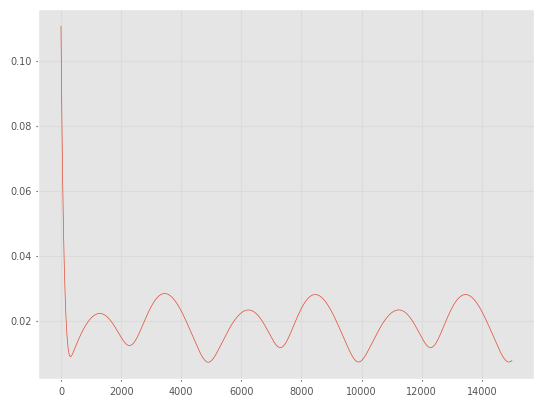

RMSE: 0.020223858348759925


In [ ]:
error_history = np.array(error_history)
plt.plot(error_history)
plt.show()

print('RMSE:', np.sqrt((error_history**2).mean()))

In [25]:
# Make a new environment and add our robot
env = Swift()
env.launch(realtime=True, browser="notebook")
env.add(robot)
env.add(ee_axes)
env.add(goal_axes)

# Change the robot configuration to the ready position
robot._T = init_robotbase.copy()
robot.qr = np.zeros(8)
robot.q = robot.qr

# Step the sim to view the robot in this configuration
env.step(0)

# A variable to specify when to break the loop
arrived = False

# Specify the gain for the p_servo method
# gain = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
gain = 0.1 * np.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0])
k_d = 0

# Specify our timestep
dt = 0.01
duration = 20

Tep = robot._T * sm.SE3.RPY(0.0, 0.0, 0.0) * sm.SE3.Trans(0.35, 0.0, 0.2)

robot._T = robot._T * sm.SE3.RPY(0.0, 0.0, -np.pi/2)

# baseMotionV = sm.SE3.Trans(0,-0.05*dt,0)
# baseMotionA = sm.SE3.RPY(0.0, 0.0, np.pi/20*dt)
# Tep = Tep.A

# Set the goal axes to Tep
goal_axes.T = Tep
time = 0
error_history = []
max_qd = np.zeros(8)

# Run the simulation for duration seconds
for _ in range(int(duration/dt)):
	# baseMotionV = sm.SE3.Trans(-np.sin(2*np.pi*time/5)*-0.05*dt,
	# 							np.cos(2*np.pi*time/5)*-0.05*dt,
	# 							0)
	# baseMotionV = sm.SE3.Trans(-np.sin(2*np.pi*time/5)*-0.05*dt,
	# 							0,
	# 							0) 
 
	# baseMotionV = sm.SE3.Trans(0.00*dt, 0, 0)# * sm.SE3.RPY(0.0, 0.0, 2*np.pi/10*dt)
	
	# Work out the base frame manipulator Jacobian using the current robot configuration
	J = robot.jacob0(robot.q, end='/ee_arm_link')

	# The end-effector pose of the robot (using .A to get a numpy array instead of an SE3 object)
	Te = robot.fkine(robot.q, end='/ee_arm_link').A

	# Since the robot has 5 joints, the Jacobian is not square, therefore we must
	# use the pseudoinverse (the pinv method)
	J_pinv = np.linalg.pinv(J)

	# Calculate the required end-effector velocity and whether the robot has arrived
	ev, arrived = p_servo(Te, Tep, gain=gain, threshold=0.001)

	# account for moving base's velocity in determining desired EE velocity
	# ev += -k_d * np.concatenate([baseMotionV.A[:3, -1]/dt, np.zeros(3)])
 
	# Calculate the required joint velocities and apply to the robot
	robot.qd = np.concatenate([J_pinv @ ev, np.zeros(dq_size - action_size)])
	# maxVal = np.abs(robot.qd).max()
	# if maxVal > 0.01:
	# 	robot.qd /= abs(maxVal)
	# 	robot.qd *= 0.05
 	
	max_qd = np.max(np.vstack([abs(robot.qd), max_qd]), axis=0)

	# Update the ee axes
	ee_axes.T = Te
	
	# robot._T = robot._T * baseMotionV

	# store error as 
	error_history.append(np.linalg.norm(Te[:3, -1] - Tep[:3, -1]))

	# Step the simulator by dt seconds
	env.step(dt)
	time += dt